In [3]:
import os
import sqlite3
import re
from datetime import datetime

# Caminho para o banco de dados
DB_PATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 
                     'data_warehouse', 'stellar_occultations.db')

import format_data

## 1 - Primeiro passo
Interagir com a Data Base. Buscar objetos e curvas, plotá-las e analisá-las

In [4]:
format_data.get_available_objects()

['1983VD7',
 '1991TF1',
 '1994XM2',
 '1998XA53',
 '1999PY3',
 '1999RU208',
 '1999TA91',
 '1999TB100',
 '1999TG246',
 '1999XR13',
 '1999XW211',
 '2000ET64',
 '2000HT75',
 '2000KJ1',
 '2000OW26',
 '2000SW106',
 '2000TK17',
 '2000WV132',
 '2001HS35',
 '2001US197',
 '2002KX14',
 '2002WC19',
 '2003GG42',
 '2003UP55',
 '2005RM43',
 '2007JJ43',
 '2014EZ51',
 'Abundantia',
 'Academia',
 'Adelheid',
 'Adelinda',
 'Admete',
 'Adorea',
 'Adria',
 'Adzhimushkaj',
 'Aegina',
 'Aegle',
 'Aeternitas',
 'Aethra',
 'Aguntina',
 'Aida',
 'Alauda',
 'Alekto',
 'Alemannia',
 'Aletheia',
 'Alfven',
 'Aline',
 'Alkmene',
 'Alphonsina',
 'Alsatia',
 'Althaea',
 'Amalia',
 'Amalthea',
 'Amata',
 'Ambrosia',
 'Anacostia',
 'Angola',
 'Ani',
 'Antenor',
 'Antigone',
 'Antilochus',
 'Antiope',
 'Antonia',
 'Arctica',
 'Arethusa',
 'Armida',
 'Artemis',
 'Asia',
 'Aspasia',
 'Asplinda',
 'Asterope',
 'Atala',
 'Atalante',
 'Ate',
 'Athamantis',
 'Aulis',
 'Aurelia',
 'Aurora',
 'Ausonia',
 'Austria',
 'Backlunda'

In [5]:
objects = format_data.get_available_objects()

# Demonstração com o primeiro objeto
selected_object = objects[:2]
selected_object

['1983VD7', '1991TF1']

In [6]:
dates = [format_data.get_observation_dates(object) for object in selected_object]
dates

[['2020-11-01'], ['2020-11-01']]

In [7]:
format_data.search_light_curves(selected_object[0], dates[0][0])

[{'observation_id': 1,
  'observer_name': 'JordiMarco',
  'is_positive': True,
  'point_count': 1198}]

In [8]:
lcs = []
for ind_objt in range(len(selected_object)):
    for date in dates[ind_objt]:
        lcs.append(format_data.search_light_curves(selected_object[ind_objt], date))
lcs

[[{'observation_id': 1,
   'observer_name': 'JordiMarco',
   'is_positive': True,
   'point_count': 1198}],
 [{'observation_id': 2,
   'observer_name': 'DHerald',
   'is_positive': True,
   'point_count': 826},
  {'observation_id': 3,
   'observer_name': 'WHanna',
   'is_positive': True,
   'point_count': 281}]]

In [9]:
lcs = [format_data.search_light_curves(selected_object[ind_objt], date) 
       for ind_objt in range(len(selected_object)) 
       for date in dates[ind_objt]]
lcs

[[{'observation_id': 1,
   'observer_name': 'JordiMarco',
   'is_positive': True,
   'point_count': 1198}],
 [{'observation_id': 2,
   'observer_name': 'DHerald',
   'is_positive': True,
   'point_count': 826},
  {'observation_id': 3,
   'observer_name': 'WHanna',
   'is_positive': True,
   'point_count': 281}]]

In [10]:
selected_object

['1983VD7', '1991TF1']

1) buscar forma de plotar as curvas que estão sendo analisadas
2) buscar forma que recortar a parte negativa automática das curvas positivas
3) guardar essas negativas extras em um dataset a parte
4) organizar e modular o dataset final para que possa ser aplicado no script model train

In [11]:
objects = format_data.get_available_objects()

# Demonstração com o primeiro objeto
selected_object = objects[:2]
print(f"\nDatas disponíveis para {selected_object}:")

dates = [format_data.get_observation_dates(object) for object in selected_object]
for date in dates:
    print(f"- {date} Encontrada")

light_curves = [format_data.search_light_curves(selected_object[ind_objt], date) 
       for ind_objt in range(len(selected_object)) 
       for date in dates[ind_objt]]

for list in light_curves:
    for lc in list:
        print(f"- {lc.get('observer_name')} (Positivo: {lc.get('is_positive')}, Pontos: {lc.get('point_count')})")


Datas disponíveis para ['1983VD7', '1991TF1']:
- ['2020-11-01'] Encontrada
- ['2020-11-01'] Encontrada
- JordiMarco (Positivo: True, Pontos: 1198)
- DHerald (Positivo: True, Pontos: 826)
- WHanna (Positivo: True, Pontos: 281)


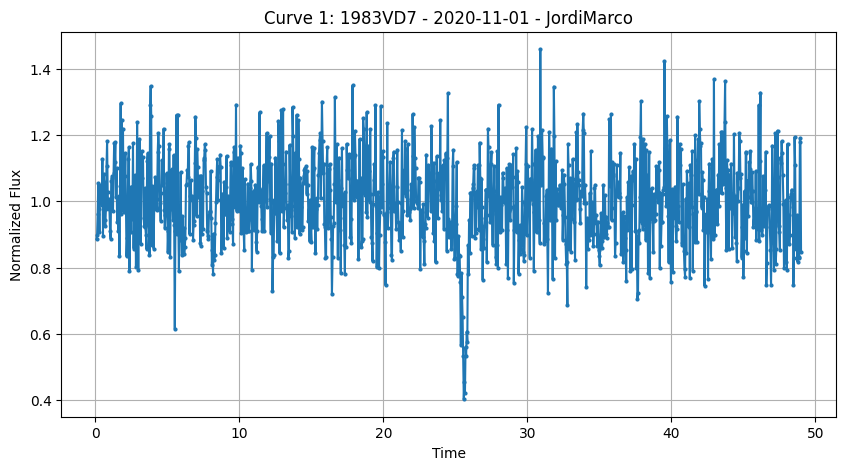

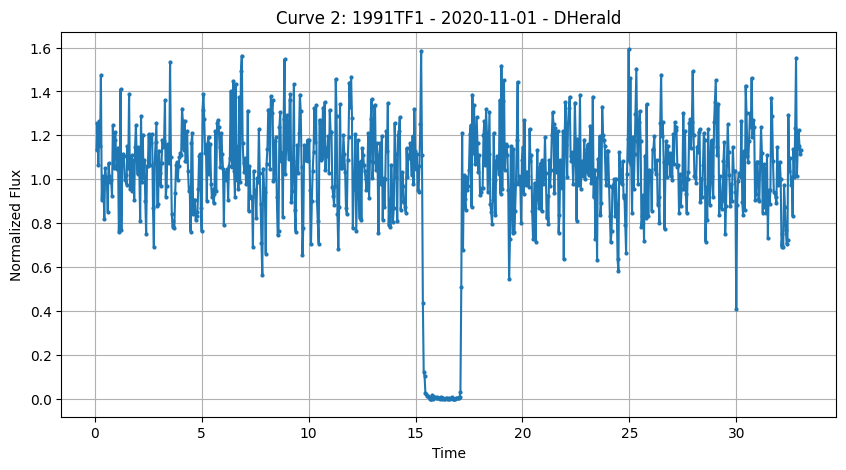

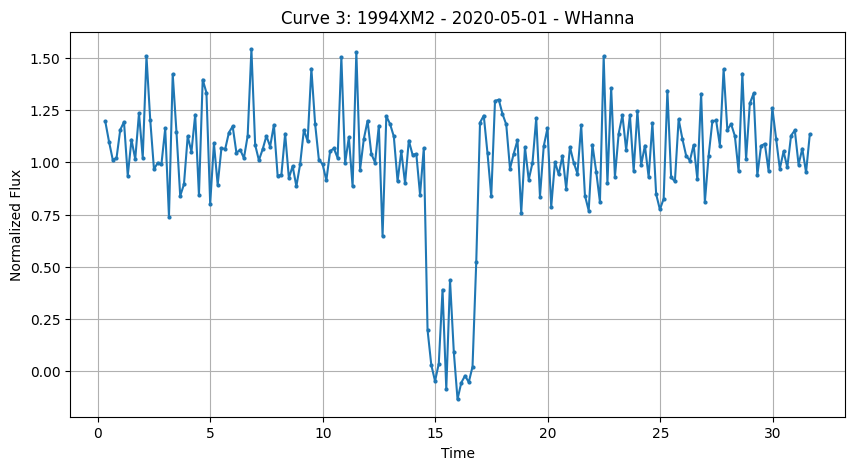

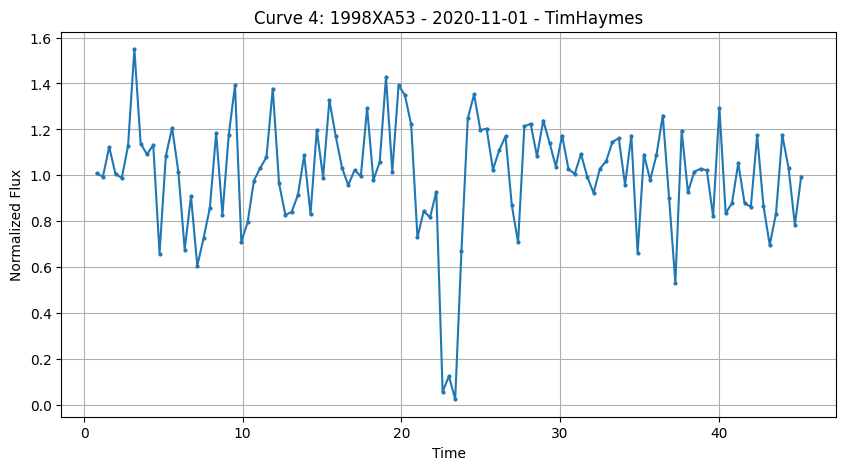

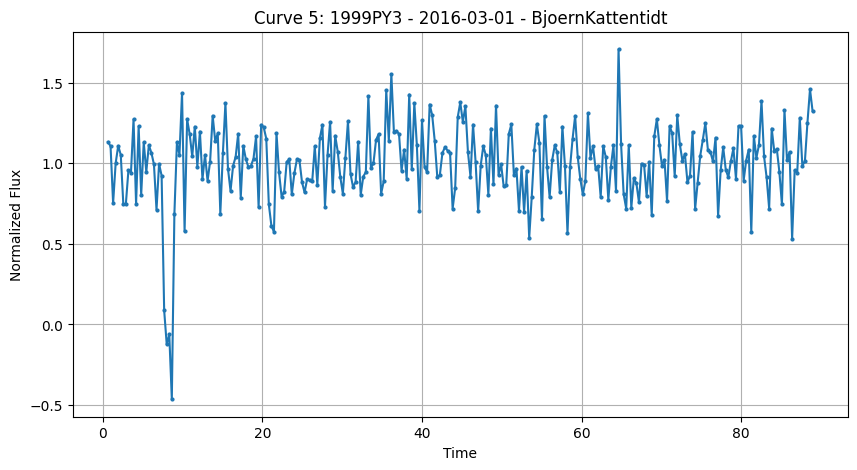

In [12]:
format_data.fetch_and_plot_first_curves(5)

## 2 - Segundo passo
Ler uma amostragem grande de curvas (+100), programar um método de recortar trechos negativos e associá-los a curvas separadas negativas. 

Ideia: separar recortes em outra variável "fake_negative".

In [13]:
import numpy as np
import pandas as pd

def buscar_curvas_objeto(object_name):
    """
    Busca todas as curvas de luz para um objeto específico.
    
    Args:
        object_name (str): Nome do objeto celeste.
    
    Returns:
        List[Tuple[curva, object_name, data, observador]]
    """
    total_curvas = []
    datas = format_data.get_observation_dates(object_name)
    for data in datas:
        # Busca todas as curvas para este objeto/data
        curvas, observadores = format_data.format_light_curve_data(None, object_name, data)
        for curva, obs in zip(curvas, observadores):
            total_curvas.append((curva, object_name, data, obs))
    return total_curvas

def buscar_curvas(max_curvas):
    objetos = format_data.get_available_objects()
    curvas_encontradas = 0
    total_curvas = []

    for obj in objetos:
        datas = format_data.get_observation_dates(obj)
        for data in datas:
            # Busca apenas 1 curva por objeto/data
            curvas, observadores = format_data.format_light_curve_data(1, obj, data)
            for curva, obs in zip(curvas, observadores):
                total_curvas.append((curva, obj, data, obs))
                curvas_encontradas += 1
                if curvas_encontradas >= max_curvas:
                    break
            if curvas_encontradas >= max_curvas:
                break
        if curvas_encontradas >= max_curvas:
            break

    return total_curvas


def remove_outliers(time, flux, z_thresh=3):
    """
    Remove outliers do fluxo usando z-score.
    """
    flux = np.array(flux)
    time = np.array(time)
    mean = np.mean(flux)
    std = np.std(flux)
    if std == 0:
        return time, flux  # Nenhum outlier possível
    z = (flux - mean) / std
    mask = np.abs(z) < z_thresh
    return time[mask], flux[mask]

def recortar_negativos(curva, margem=10, threshold=0.8, min_tamanho=20, z_thresh=3):
    """
    Recorta trechos negativos (sem ocultação) de uma curva positiva, com limpeza de outliers.
    """
    time = np.array(curva[0][0].get('time'))
    flux = np.array(curva[0][0].get('flux_normalized'))

    # Limpeza de outliers
    time, flux = remove_outliers(time, flux, z_thresh=z_thresh)

    # Identifica pontos de ocultação
    ocultando = flux < threshold
    if not np.any(ocultando):
        # Não há ocultação, retorna a curva toda como negativa
        return [pd.DataFrame({'time': time, 'flux_normalized': flux})]

    # Encontra início e fim do evento
    indices = np.where(ocultando)[0]
    inicio = indices[0]
    fim = indices[-1]

    # Trecho antes da ocultação
    antes = slice(0, max(0, inicio - margem))
    # Trecho depois da ocultação
    depois = slice(min(len(time), fim + margem), len(time))

    negativos = []
    if (antes.stop - antes.start) >= min_tamanho:
        negativos.append(pd.DataFrame({'time': time[antes], 'flux_normalized': flux[antes]}))
    if (depois.stop - depois.start) >= min_tamanho:
        negativos.append(pd.DataFrame({'time': time[depois], 'flux_normalized': flux[depois]}))

    return negativos

In [17]:
buscar_curvas_objeto('Umbriel')

[({'time': [2459113.84763774,
    2459113.84764932,
    2459113.8476609,
    2459113.84767249,
    2459113.84768407,
    2459113.84769566,
    2459113.84770724,
    2459113.84771882,
    2459113.84773041,
    2459113.84774199,
    2459113.84775357,
    2459113.84776516,
    2459113.84777674,
    2459113.84778832,
    2459113.84779991,
    2459113.84781149,
    2459113.84782308,
    2459113.84783466,
    2459113.84784624,
    2459113.84785783,
    2459113.84786941,
    2459113.84788099,
    2459113.84789258,
    2459113.84790416,
    2459113.84791574,
    2459113.84792733,
    2459113.84793891,
    2459113.84795049,
    2459113.84796208,
    2459113.84797366,
    2459113.84798525,
    2459113.84799683,
    2459113.84800841,
    2459113.84802,
    2459113.84803158,
    2459113.84804316,
    2459113.84805475,
    2459113.84806633,
    2459113.84807791,
    2459113.8480895,
    2459113.84810108,
    2459113.84811267,
    2459113.84812425,
    2459113.84813583,
    2459113.84814742,
    245

In [ ]:
curva_1 = buscar_curvas(1)
negativos = recortar_negativos(curva_1)
negativos

({'time': [0.0817362,
   0.122604,
   0.163472,
   0.204341,
   0.245209,
   0.286077,
   0.326945,
   0.367813,
   0.408681,
   0.449549,
   0.490417,
   0.531285,
   0.572154,
   0.613022,
   0.65389,
   0.694758,
   0.735626,
   0.776494,
   0.817362,
   0.85823,
   0.899098,
   0.939967,
   0.980835,
   1.0217,
   1.06257,
   1.10344,
   1.14431,
   1.18518,
   1.22604,
   1.26691,
   1.30778,
   1.34865,
   1.38952,
   1.43038,
   1.47125,
   1.51212,
   1.55299,
   1.59386,
   1.63472,
   1.67559,
   1.71646,
   1.75733,
   1.7982,
   1.83907,
   1.87993,
   1.9208,
   1.96167,
   2.00254,
   2.04341,
   2.08427,
   2.12514,
   2.16601,
   2.20688,
   2.24775,
   2.28861,
   2.32948,
   2.37035,
   2.41122,
   2.45209,
   2.49295,
   2.53382,
   2.57469,
   2.61556,
   2.65643,
   2.6973,
   2.73816,
   2.77903,
   2.8199,
   2.86077,
   2.90164,
   2.9425,
   2.98337,
   3.02424,
   3.06511,
   3.10598,
   3.14684,
   3.18771,
   3.22858,
   3.26945,
   3.31032,
   3.35119,
   3

 - Comparando a curva inteira com a parte negativa recortada:

<Axes: xlabel='time'>

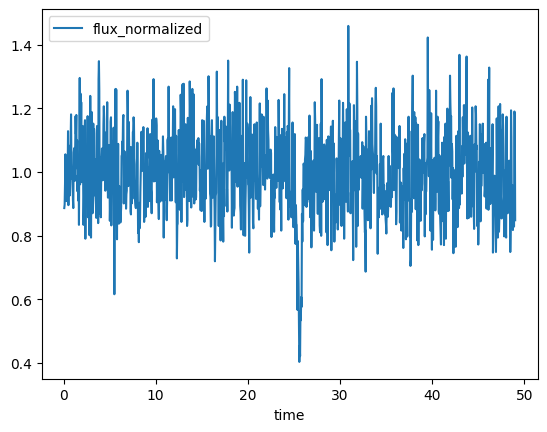

In [ ]:
data_frame_curva_1 = pd.DataFrame(curva_1[0][0])
data_frame_curva_1.plot(x='time', y='flux_normalized')

<Axes: xlabel='time'>

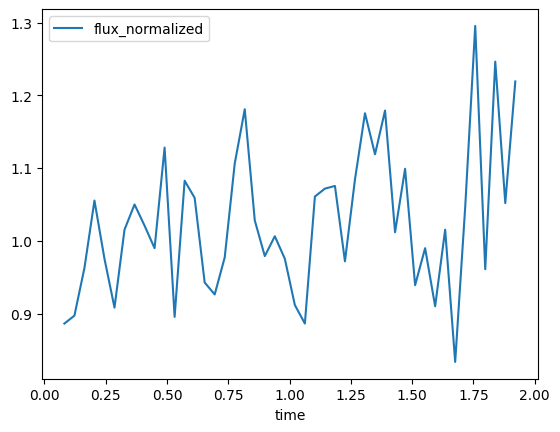

In [37]:
negativos[0].plot(x='time', y='flux_normalized')

Podemos considerar essas curvas como outras negativas, para aumentar nosso dataset.

## 3 - Terceiro passo
Organizar variáveis de curvas lidas, aplicar feature engineering e criar DataSet de treino/validação.